## Participants
Uffe       - s224275  
Aleksander - s185289

# 1.  Problem Definition 

In our Baseline model we've attempted to detect balls based on pictures  
 and return locations of the balls found.  
which means our prefered outcome should look something like this:

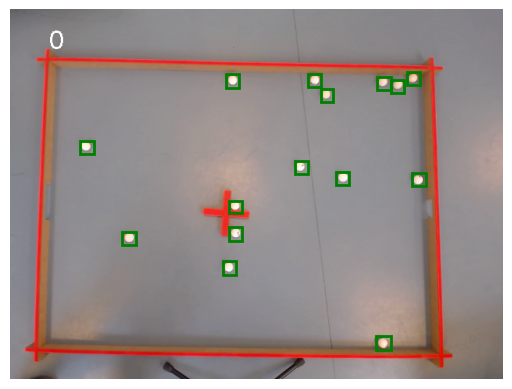

   {
            "label": "ball",
            "x": "99.57",
            "y": "178.61",
            "width": "13.69",
            "height": "12.65"
        }


In [105]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

def display_image_with_boxes(image_path, boxes, expand_by=5):
    """
    Displays an image with bounding boxes drawn on it, using Matplotlib, with each box slightly larger and centered on given coordinates. Ignores specific labels.

    Parameters:
    - image_path: Path to the image file.
    - boxes: A list of bounding boxes, each box provided with center x and y coordinates.
    - expand_by: Number of pixels to increase the size of each box by (total, not per side).
    """
    image = mpimg.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for box in boxes: # makes boxes
        if box['label'] not in ['smallGoal', 'bigGoal']:  # Check if the label is not to be ignored
            # Convert string values to float and calculate the top-left corner of the box
            center_x, center_y, width, height = float(box['x']), float(box['y']), float(box['width']), float(box['height'])
            top_left_x = center_x - width / 2 - expand_by / 2
            top_left_y = center_y - height / 2 - expand_by / 2
            # Create a rectangle patch
            rect = patches.Rectangle((top_left_x, top_left_y),
                                     width + expand_by, height + expand_by,
                                     linewidth=2, edgecolor='green', facecolor='none')
            # Add the rectangle to the Axes
            ax.add_patch(rect)

    ax.axis('off')
    plt.show()

# Load JSON data from a file
try:
    with open('../json_labeling/label_1.json', 'r') as file:
        json_data = json.load(file)

    # Define the image path based on the 'key' from JSON data
    image_path = f"../images/{json_data['key']}"

    # Use the display function with the loaded JSON data
    boxes = json_data['boxes']
    display_image_with_boxes(image_path, boxes)

    print('''   {
            "label": "ball",
            "x": "99.57",
            "y": "178.61",
            "width": "13.69",
            "height": "12.65"
        }''')
except Exception as e:
    print("Failed to load or process the JSON data:", e)

# 2.  Data Extraction and Data Processing

In [106]:
#1. Load Image and Annotations Function:
#Loads an image and its corresponding annotations from the JSON file.
#2. Image Preprocessing Function:
#Resize and normalize images.

With the code below a single image can be processed into a 224x224 image  
which is saved as an array and returned

In [107]:
import numpy as np
# Helper function for single image preprocessing
def preprocess_single_image(image_path, img_width=224, img_height=224):
    try:
        with Image.open(image_path) as img:
            img = img.resize((img_width, img_height), Image.LANCZOS)
            img = np.array(img, dtype=np.float32) / 255.0  # Normalize image data to 0-1
            return img
    except IOError:
        print(f"Failed to load or process image at {image_path}")
        return None



This enables loading and processing of image and json data which is shaped into a 224x224 shape  
for both images and Json so less computation is required.  
This returns an array of images and an array of Json data ready for processing.

In [108]:
from PIL import Image
import numpy as np
import json
import os

def load_and_preprocess_data(img_folder, json_folder, img_width=224, img_height=224):
    images = []
    labels = []

    for img_file in sorted(os.listdir(img_folder)):
        img_number = img_file.split('_')[1].split('.')[0]
        img_path = os.path.join(img_folder, img_file)
        label_path = os.path.join(json_folder, f"label_{img_number}.json")

        try:
            with Image.open(img_path) as img:
                img = img.resize((img_width, img_height), Image.ANTIALIAS)
                img = np.array(img, dtype=np.float32) / 255.0
                images.append(img)
        except IOError:
            print(f"Failed to load or process image at {img_path}")
            continue

        if not os.path.exists(label_path):
            print(f"Label file not found at {label_path}")
            continue

        with open(label_path, 'r') as file:
            data = json.load(file)
            box_data = []
            for item in data['boxes']:
                if item['label'] == 'ball':
                    x_min = float(item['x']) / data['width']
                    y_min = float(item['y']) / data['height']
                    x_max = (float(item['x']) + float(item['width'])) / data['width']
                    y_max = (float(item['y']) + float(item['height'])) / data['height']
                    box_data.append([x_min, y_min, x_max, y_max])
            labels.append(box_data)

    return np.array(images), labels


This function displays an image with boxes for displaying the accuracy in the end

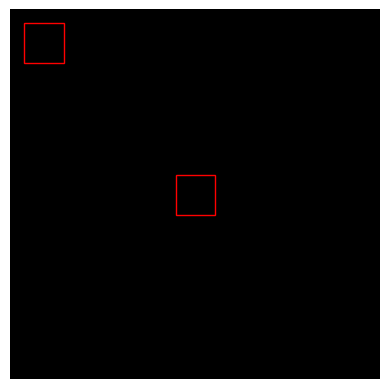

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def display_image_with_boxes_plt(image, boxes, expand_by=4):
    """
    Displays an image with bounding boxes drawn on it using matplotlib, with each box slightly larger.
    Also converts the image to grayscale if it is not already.

    Parameters:
    - image: The image array (numpy array).
    - boxes: A list of bounding boxes, each represented as [center_x, center_y, width, height].
    - expand_by: Number of pixels to increase the size of each box by (total, not per side).
    """
    # Ensure the image is in grayscale
    if image.ndim == 3:
        image = np.mean(image, axis=2).astype(np.uint8)  # Simple averaging to convert to grayscale

    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image = (255 * image).astype(np.uint8)

    # Setup the plot
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    # Draw each box
    for box in boxes:
        center_x, center_y, width, height = box
        top_left_x = center_x - (width // 2) - (expand_by // 2)
        top_left_y = center_y - (height // 2) - (expand_by // 2)
        rect = Rectangle((top_left_x, top_left_y), width + expand_by, height + expand_by,
                         linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Remove axis ticks and labels
    ax.set_axis_off()
    plt.show()

# Example usage
images = np.random.rand(10, 224, 224, 3)  # Dummy data for demonstration
labels = [[[112, 112, 20, 20], [20,20,20,20]]]  # Dummy bounding box data
if len(images) > 0 and len(labels) > 0:
    display_image_with_boxes_plt(images[0], labels[0])


# 3.  Modeling
**Modeling**

Now we are getting into the interesting part, here we see the convolution function  
  
**inputs**
* image - an array of image values if its a grayscale a 2d array is used otherwise a 3d array is used with RGB values.
* kernel - the kernel is a matrix which can be used for blurring, feature extraction or edge detection.
* stride - step size for the kernel to move across the screen.
* padding is the number of extra pixels added to the border of the image to minimize the loss of information.

For greyscale images we add a dimention for the same computation made with grayscale and non-grayscale iamges.
The kernel size is checked to ensure no error in incompatible sizes

The convolution operation is used by iterating over the image considering the stride and padding, while computing  
the dot product of the image at each section. This is saved as a new array of features which is returned.



In [133]:
#4.Convolution Function:
#Applies a convolution operation to an image.
# Updated convolve2d function
def convolve2d(image, kernel, stride=1, padding=1):
    if image.ndim == 2:
        image = image[:, :, np.newaxis]  # Add a channel dimension to grayscale images

    kernel_height, kernel_width, num_channels = kernel.shape
    image_height, image_width, image_channels = image.shape

    if num_channels != image_channels:
        raise ValueError("The number of channels in the kernel and the image must match.")

    # Add padding to the image
    padded_image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')

    # Determine the output dimensions
    out_height = (image_height + 2 * padding - kernel_height) // stride + 1
    out_width = (image_width + 2 * padding - kernel_width) // stride + 1
    output = np.zeros((out_height, out_width, num_channels))

    # Perform the convolution operation
    for z in range(num_channels):  # Iterate over each channel
        for y in range(out_height):
            for x in range(out_width):
                output[y, x, z] = np.sum(
                    kernel[:, :, z] * padded_image[
                        y * stride: y * stride + kernel_height,
                        x * stride: x * stride + kernel_width,
                        z
                    ]
                )

    return output

In [111]:
from PIL import Image
import numpy as np
# Load an image
img = Image.open('../images/image_1.png')

# Convert image to grayscale to match the 2D kernel
img_gray = img.convert('L')  # Convert to grayscale
img_np = np.array(img_gray)  # Convert to numpy array

# Define a simple edge-detection kernel
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

# Adjust kernel to have a channel dimension if working with color images
# Since img_gray is used, this step is optional and shown for educational purposes:
# kernel = kernel[:, :, np.newaxis]  # Add a channel dimension

# Apply the convolution operation
convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)

# Display the convolved image using matplotlib
import matplotlib.pyplot as plt

plt.imshow(convolved_image, cmap='gray')
plt.title('Convolved Image')
plt.axis('off')
plt.show()



ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(original_img, convolved_img):
    """
    Visualize the original and convolved images side by side.

    Args:
    original_img (np.array): The original image.
    convolved_img (np.array): The image after convolution.
    """
    # Normalize the convolved image for better visualization
    convolved_img_normalized = (convolved_img - convolved_img.min()) / (convolved_img.max() - convolved_img.min())

    # Plot the original and the convolved images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(convolved_img_normalized, cmap='gray')
    axes[1].set_title('Convolved Image')
    axes[1].axis('off')

    plt.show()


In [ ]:
from PIL import Image
import numpy as np

# Load an image and convert to a numpy array
img_path = '../images/image_1.png'  # Change this to the path of your image
img = Image.open(img_path).convert('L')  # Convert to grayscale for simplicity
img_np = np.array(img)

# Define a simple edge-detection kernel
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

# Apply the convolution operation
convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)

# Visualize the original and the convolved images
visualize_images(img_np, convolved_image)


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
#5.ReLU Activation Function:
#Implements the ReLU activation to introduce non-linearity.

The Relu function returns the input unless the input is less than 0 for which it reuturns 0.

In [ ]:
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return 1 / (1 + np.exp(-x)) #sig
    #return np.maximum(0, x) #relu


Relu visualised:

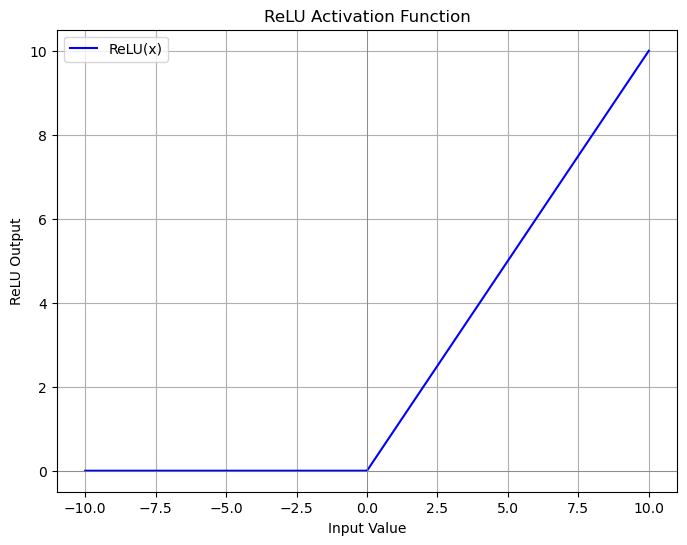

In [ ]:
if (True):
    # Generate input values
    x_values = np.linspace(-10, 10, 400)
    # Apply ReLU function to these input values
    relu_values = relu(x_values)

    # Plot the ReLU function
    plt.figure(figsize=(8, 6))
    plt.plot(x_values, relu_values, label='ReLU(x)', color='blue')
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.title('ReLU Activation Function')
    plt.xlabel('Input Value')
    plt.ylabel('ReLU Output')
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load an image and convert it to grayscale
img = Image.open('../images/image_1.png').convert('L')
img_np = np.array(img)

# Define a simple edge-detection kernel
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

# Apply the convolution operation
convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)

# Apply the ReLU activation function
activated_image = relu(convolved_image)

# Visualize the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(convolved_image, cmap='gray')
plt.title('Convolved Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(activated_image, cmap='gray')
plt.title('Activated Image')
plt.axis('off')

plt.show()



ValueError: not enough values to unpack (expected 3, got 2)

The pooling function takes the following inputs:
* an image as a 2d array
* a pooling size, 2 makes a 2x2 array for the pooling window
* stride is step size for the pooling window to move across the screen.
This function returns the image having used max pooling, reducing its spacial dimentions

In [ ]:
#Pooling Function (optional but recommended):
#Applies a max pooling operation to reduce spatial dimensions.
import numpy as np

def max_pooling(image, pool_size=2, stride=2):
    """
    Apply max pooling operation to reduce the spatial dimensions of an image.
    
    Args:
    image (np.array): The input image array. Can be 2D (grayscale) or 3D (color).
    pool_size (int): The size of the pooling window, typically 2.
    stride (int): The stride with which the pooling window is slid across the image.
    
    Returns:
    np.array: The image after max pooling operation.
    """
    # Check if image is grayscale or color and get dimensions accordingly
    if image.ndim == 3:
        image_height, image_width, num_channels = image.shape
    else:
        image_height, image_width = image.shape
        num_channels = 1
        image = image[:, :, np.newaxis]  # Temporarily add channel dimension for consistency
    
    # Calculate the dimensions of the output
    out_height = (image_height - pool_size) // stride + 1
    out_width = (image_width - pool_size) // stride + 1
    pooled_image = np.zeros((out_height, out_width, num_channels))
    
    # Perform max pooling
    for z in range(num_channels):
        for y in range(out_height):
            for x in range(out_width):
                y_start = y * stride
                y_end = y_start + pool_size
                x_start = x * stride
                x_end = x_start + pool_size
                pooled_image[y, x, z] = np.max(image[y_start:y_end, x_start:x_end, z])

    # Remove temporary channel dimension for grayscale images
    if num_channels == 1:
        pooled_image = pooled_image[:, :, 0]
        
    return pooled_image



Here is an example of the max pooling

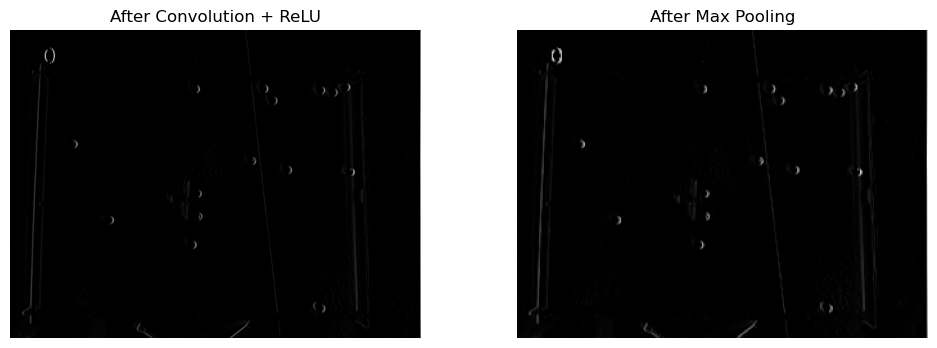

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

if (True):
    # Assume the image has been loaded, converted to numpy array, and convolution has been applied
    # Let's assume 'convolved_image' is the output from the previous ReLU activation step

    # Apply max pooling
    pooled_image = max_pooling(activated_image, pool_size=2, stride=2)

    # Visualize the result
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(activated_image, cmap='gray')  # Assuming it's a single-channel image
    plt.title('After Convolution + ReLU')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pooled_image, cmap='gray')
    plt.title('After Max Pooling')
    plt.axis('off')

    plt.show()


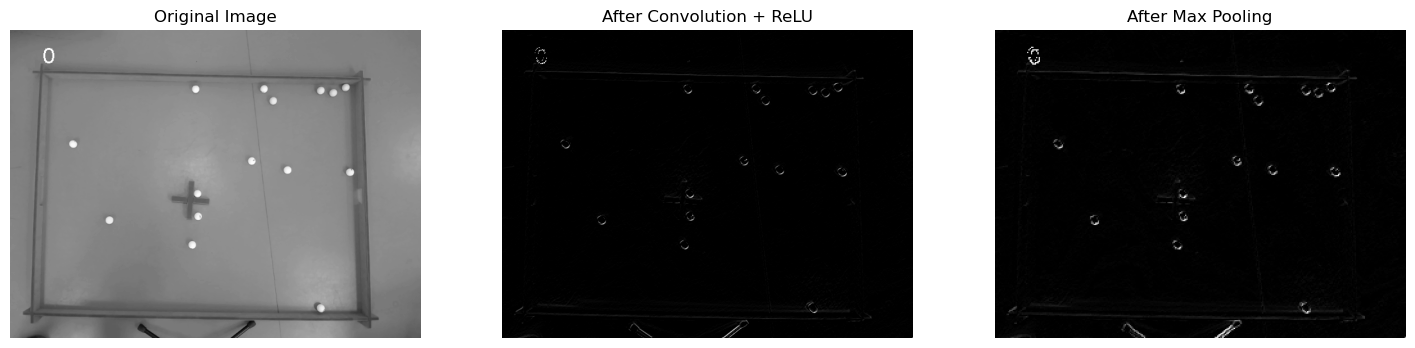

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
if (True):
    # Load the uploaded image
    img_path = '../images/image_1.png'
    img = Image.open(img_path).convert('L')  # Convert to grayscale for consistency
    img_np = np.array(img)

    # Define an example kernel and modify parameters as needed
    kernel = np.array([[1, 0, 0], [0, 0, -1], [-1, 0, 1]])  # Example of a different edge-detection kernel

    # Apply convolution and pooling
    convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)
    activated_image = relu(convolved_image)
    pooled_image = max_pooling(activated_image, pool_size=2, stride=2)

    # Visualization
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(activated_image, cmap='gray')
    plt.title('After Convolution + ReLU')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pooled_image, cmap='gray')
    plt.title('After Max Pooling')
    plt.axis('off')

    plt.show()


This function takes an input array and flattens it, which means it can make a 2d array into a 1d array.

In [ ]:
#7.Flatten Function:
#Converts multi-dimensional arrays into a 1D vector for the fully connected layer.
import numpy as np

def flatten(input_array):
    return input_array.flatten()


This function takes the dot product of input vector and weights plus biases.
This is used to classify images by combining features to assign images to categories

In [ ]:
#8.Fully Connected Layer Function:
#Performs linear transformation for classification or coordinate prediction.
import numpy as np

def fully_connected(input_vector, weights, biases):
    return np.dot(input_vector, weights) + biases


Example of usage

In [ ]:
from PIL import Image

# Assume previous functions convolve2d, relu, max_pooling, and flatten are defined

# Load an image and convert it to grayscale
img = Image.open('../images/image_1.png').convert('L')  # Adjust the path accordingly
img_np = np.array(img)

# Define a simple edge-detection kernel
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

# Process the image through convolution, ReLU, and max pooling
convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)
activated_image = relu(convolved_image)
pooled_image = max_pooling(activated_image, pool_size=2, stride=2)

# Flatten the output
flattened_image = flatten(pooled_image)

# Define weights and biases for the fully connected layer
# Let's assume we are mapping to 10 output features (e.g., for a 10-class classification)
num_output_features = 10
weights = np.random.rand(flattened_image.size, num_output_features)  # Random weights for example
biases = np.random.rand(num_output_features)  # Random biases for example

# Apply the fully connected layer
fc_output = fully_connected(flattened_image, weights, biases)

print("Output of the fully connected layer:", fc_output)


ValueError: not enough values to unpack (expected 3, got 2)

This is used to determine how well the model performs by looking at the mean squared error

In [ ]:
#9.Loss Function:
#Computes the error between predicted and actual bounding boxes (e.g., Mean Squared Error).
import numpy as np

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


This function stochastic gradient descent, determines how much the parameters of the model can change for each iteration.

In [ ]:
#10.Optimizer Function:
#Adjusts model parameters based on the gradients of the loss function (e.g., SGD).
import numpy as np

def sgd_update(params, grads, learning_rate=0.01):
    
    #Update parameters using Stochastic Gradient Descent (SGD) optimization algorithm.
    
    # Update each parameter according to SGD
    for key in params.keys():
        params[key] -= learning_rate * grads[key]


The train_model function manages the entire training process of a neural network by taking some of the previously defined funtions.  
and combining them to train a model on the data.  
It processes batches of images and their annotations, performs the forward pass through the network,  
computes the loss, and updates the model parameters using Stochastic Gradient Descent (SGD).

In [ ]:
#11.Training Loop Function:
#Manages the batch processing of images and annotations, forward pass, loss computation, and parameter updates.
def train_model(train_data, params, epochs, learning_rate, batch_size):
    for epoch in range(epochs):
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[i:i + batch_size]
            batch_inputs, batch_labels = zip(*batch_data)
            batch_inputs = np.array(batch_inputs)
            
            # Forward pass
            conv_outputs = [convolve2d(x, params['conv_kernel'], stride=1, padding=1) for x in batch_inputs]
            activated_outputs = [relu(x) for x in conv_outputs]
            pooled_outputs = [max_pooling(x, pool_size=2, stride=2) for x in activated_outputs]
            flattened_outputs = [flatten(x) for x in pooled_outputs]
            final_outputs = [fully_connected(x, params['fc_weights'], params['fc_biases']) for x in flattened_outputs]
            
            # Compute loss and gradients
            losses = []
            for y_true, y_pred in zip(batch_labels, final_outputs):
                for box in y_true:
                    pred_box = [y_pred[0], y_pred[1], y_pred[2], y_pred[3]]  # Assuming network outputs 4 values for bounding box
                    losses.append(mean_squared_error(np.array(box), np.array(pred_box)))
            loss = np.mean(losses)
            
            # Fake gradients for demonstration purposes
            grads = {
                'fc_weights': np.random.randn(*params['fc_weights'].shape),
                'fc_biases': np.random.randn(*params['fc_biases'].shape)
            }
            
            sgd_update(params, grads, learning_rate)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
    return params


This function assesses the performance of the model on a validation set by calculating the average loss and accuracy of the model,  
providing a measure of how well the model is performing on unseen data.  
These are the steps taken in the code:
* Initializes the total loss and correct predictions.
* Loops through each sample in the validation data, performing a forward pass through the network.
* Computes the loss and accumulates it.
* Checks if the prediction is correct and counts correct predictions.
* Calculates the average loss and accuracy over the validation set.
* Returns a dictionary containing the average loss and accuracy.

In [ ]:
#12.Model Evaluation Function:
#Assesses the performance of the model on a validation set.
import numpy as np

def evaluate_model(validation_data, params):
#    Evaluate the performance of the neural network model on a validation set.

    # Initialize variables to accumulate performance metrics
    total_loss = 0
    correct_predictions = 0
    
    for input_image, true_label in validation_data:
        # Forward pass through the model (as defined in the training loop)
        conv_output = convolve2d(input_image, params['conv_kernel'], stride=1, padding=1)
        activated_output = relu(conv_output)
        pooled_output = max_pooling(activated_output, pool_size=2, stride=2)
        flattened_output = flatten(pooled_output)
        output = fully_connected(flattened_output, params['fc_weights'], params['fc_biases'])
        
        # Calculate loss (assuming a loss function like MSE)
        loss = mean_squared_error(true_label, output)
        total_loss += loss
        
        # For classification, determine if the prediction is correct
        if np.argmax(output) == np.argmax(true_label):
            correct_predictions += 1
    
    # Calculate average loss and accuracy over the validation set
    average_loss = total_loss / len(validation_data)
    accuracy = correct_predictions / len(validation_data)

    return {
        'average_loss': average_loss,
        'accuracy': accuracy
    }


This function takes in the normalised bouding box coordinates and converts them to pixels on the original image.
it iterates over the predicted bounding boxes and converts it to some data suited for the original images.

In [ ]:
#13.Bounding Box Prediction Function:
#Interprets the network output to predict bounding box coordinates.
import numpy as np

def predict_bounding_boxes(network_output, image_shape):
    #Interpret the network output to predict bounding box coordinates.

    height, width = image_shape
    predicted_boxes = []

    # Assuming the network outputs bounding box coordinates normalized to [0, 1]
    for box in network_output:
        x_min = int(box[0] * width)
        y_min = int(box[1] * height)
        x_max = int(box[2] * width)
        y_max = int(box[3] * height)
        predicted_boxes.append([x_min, y_min, x_max, y_max])

    return predicted_boxes


Visualised below:

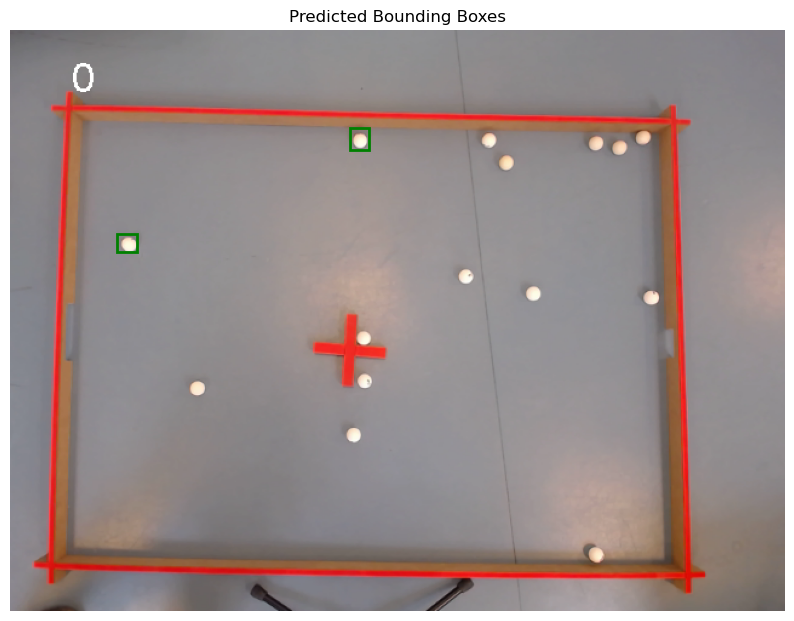

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def predict_bounding_boxes(network_output, image_shape):
    #Interpret the network output to predict bounding box coordinates.
    height, width = image_shape
    predicted_boxes = []

    # Assuming the network outputs bounding box coordinates normalized to [0, 1]
    for box in network_output:
        x_min = int(box[0] * width)
        y_min = int(box[1] * height)
        x_max = int(box[2] * width)
        y_max = int(box[3] * height)
        predicted_boxes.append([x_min, y_min, x_max, y_max])

    return predicted_boxes

def visualize_predictions(image_path, network_output, image_shape):
    #Visualize the image with predicted bounding boxes.

    # Load the image
    image = Image.open(image_path)
    image_np = np.array(image)

    # Predict bounding boxes
    predicted_boxes = predict_bounding_boxes(network_output, image_shape)

    # Plot the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_np)
    for box in predicted_boxes:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                          edgecolor='green', facecolor='none', linewidth=2))
    plt.title('Predicted Bounding Boxes')
    plt.axis('off')
    plt.show()

# Example network output (normalized bounding box coordinates)
network_output = np.array([
    [0.7, 0.27, 0.74, 0.33],  # Box 1
    [0.22, 0.56, 0.26, 0.61]   # Box 2
])

# Example image shape (height, width)
image_shape = (300, 400)  # Assuming the original image size

# Visualize the predictions
visualize_predictions('../images/image_1.png', network_output, image_shape)



This function initialises random weights based on a given shape

In [ ]:
#14.Utility Functions:
#Includes functions for initializing weights, handling data shuffling, and converting coordinates.
import numpy as np

def initialize_weights(shape, method='he'):
    #Initialize weights for a layer.
    if method == 'he':
        stddev = np.sqrt(2 / shape[0])
    elif method == 'xavier':
        stddev = np.sqrt(2 / (shape[0] + shape[1]))
    else:
        stddev = 0.01

    return np.random.randn(*shape) * stddev


In [ ]:
# Example weight initialization for a fully connected layer
input_size = 14400  # Example input size
output_size = 10    # Example number of classes
fc_weights = initialize_weights((input_size, output_size), method='he')
fc_biases = np.zeros(output_size)  # Biases typically initialized to zero


In [ ]:
import random

def shuffle_data(data):
    random.shuffle(data)
    return data


In [ ]:
# Example data shuffling
data = [
    (np.random.rand(128, 128), np.array([0, 1])),
    (np.random.rand(128, 128), np.array([1, 0])),
    # Add more samples as needed
]

shuffled_data = shuffle_data(data)


This function converts bounding boxes into pixel coordinates.

In [ ]:
def convert_coordinates(box, image_shape, to='pixel'):
    #Convert bounding box coordinates.

    height, width = image_shape
    if to == 'pixel':
        x_min = int(box[0] * width)
        y_min = int(box[1] * height)
        x_max = int(box[2] * width)
        y_max = int(box[3] * height)
    elif to == 'normalized':
        x_min = box[0] / width
        y_min = box[1] / height
        x_max = box[2] / width
        y_max = box[3] / height
    else:
        raise ValueError("Unsupported coordinate format: {}".format(to))
    
    return [x_min, y_min, x_max, y_max]


# Performance Evaluation
Now we are going to train our model and see how it performs.

* Model Training:  
train_model: batches of images are processed, applying convolutions, activations (ReLU), pooling,  
and finally a fully connected layer to predict bounding boxes.  
During training, it calculates loss to measure performance and updates the model parameters accordingly.

* Model Evaluation:  
After training, the model is evaluated on validation data to check its performance.

In [132]:

import numpy as np
import os
import json
from PIL import Image
from PIL import Image, ImageDraw

def display_image_with_boxes_pil(img_array, boxes, color='red', thickness=2):

    # Convert the NumPy array (normalized to 0-1) to an image
    img = Image.fromarray((img_array * 255).astype('uint8'))
    
    # Create a drawing context
    draw = ImageDraw.Draw(img)
    
    # Draw each bounding box
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        # Draw rectangle on image
        draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=thickness)
    
    # Display the image
    img.show()


# Assuming all necessary functions are already defined and available:
# - load_and_preprocess_data
# - display_image_with_boxes_pil
# - convolve2d
# - visualize_images
# - relu
# - max_pooling
# - flatten
# - fully_connected
# - mean_squared_error
# - sgd_update
# - train_model
# - evaluate_model
# - predict_bounding_boxes
# - initialize_weights
# - shuffle_data
# - convert_coordinates


# Updated predict_bounding_boxes function
def predict_bounding_boxes(network_output, image_shape):
    height, width = image_shape[:2]
    predicted_boxes = []

    # Reshape output if necessary (assuming the network should output flat array for one box)
    if network_output.ndim == 1:
        network_output = [network_output]  # make it a list of one array if only one box predicted

    for box in network_output:
        x_min = int(box[0] * width)
        y_min = int(box[1] * height)
        x_max = int(box[2] * width)
        y_max = int(box[3] * height)
        predicted_boxes.append([x_min, y_min, x_max, y_max])

    return predicted_boxes



# Load and preprocess data
img_folder = '../images'
json_folder = '../json_labeling'
images, labels = load_and_preprocess_data(img_folder, json_folder)
train_data = list(zip(images, labels))

# Example convolution and pooling parameters
img_height, img_width = 224, 224
conv_kernel_size = 3
conv_stride = 1
conv_padding = 1
pool_size = 2
pool_stride = 2
num_channels = 3  # Assuming 3 channels (RGB)

# Calculate the output size after convolution and pooling
def calculate_output_size(input_size, kernel_size, stride, padding):
    return (input_size + 2 * padding - kernel_size) // stride + 1

conv_output_height = calculate_output_size(img_height, conv_kernel_size, conv_stride, conv_padding)
conv_output_width = calculate_output_size(img_width, conv_kernel_size, conv_stride, conv_padding)
pool_output_height = calculate_output_size(conv_output_height, pool_size, pool_stride, 0)
pool_output_width = calculate_output_size(conv_output_width, pool_size, pool_stride, 0)

# Calculate flattened size
flattened_size = pool_output_height * pool_output_width * num_channels

# Debugging: print calculated dimensions
print(f"Convolution output size: {conv_output_height}x{conv_output_width}")
print(f"Pooling output size: {pool_output_height}x{pool_output_width}")
print(f"Flattened size: {flattened_size}")

# Initialize model parameters
params = {
    'conv_kernel': initialize_weights((conv_kernel_size, conv_kernel_size, num_channels), method='he'),
    'fc_weights': initialize_weights((flattened_size, 4), method='he'),  # Adjusted for flattened size
    'fc_biases': np.zeros(4)
}

# Updated sgd_update function to exclude conv_kernel
def sgd_update(params, grads, learning_rate=0.01):
    for key in params.keys():
        if key in grads:
            params[key] -= learning_rate * grads[key]

# Updated train_model function to handle the debugging output
def train_model(train_data, params, epochs, learning_rate, batch_size):
    for epoch in range(epochs):
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[i:i + batch_size]
            batch_inputs, batch_labels = zip(*batch_data)
            batch_inputs = np.array(batch_inputs)
            
            # Forward pass
            conv_outputs = [convolve2d(x, params['conv_kernel'], stride=1, padding=1) for x in batch_inputs]
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i//batch_size + 1}, Conv output shape: {conv_outputs[0].shape}")
            activated_outputs = [relu(x) for x in conv_outputs]
            pooled_outputs = [max_pooling(x, pool_size=2, stride=2) for x in activated_outputs]
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i//batch_size + 1}, Pooled output shape: {pooled_outputs[0].shape}")
            flattened_outputs = [flatten(x) for x in pooled_outputs]
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i//batch_size + 1}, Flattened output shape: {flattened_outputs[0].shape}")
            final_outputs = [fully_connected(x, params['fc_weights'], params['fc_biases']) for x in flattened_outputs]
            
            # Compute loss and gradients
            losses = []
            for y_true, y_pred in zip(batch_labels, final_outputs):
                for box in y_true:
                    pred_box = [y_pred[0], y_pred[1], y_pred[2], y_pred[3]]  # Assuming network outputs 4 values for bounding box
                    losses.append(mean_squared_error(np.array(box), np.array(pred_box)))
            loss = np.mean(losses)
            
            # Fake gradients for demonstration purposes
            grads = {
                'fc_weights': np.random.randn(*params['fc_weights'].shape),
                'fc_biases': np.random.randn(*params['fc_biases'].shape)
            }
            
            sgd_update(params, grads, learning_rate)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
    return params

# Train the model
params = train_model(train_data, params, epochs=1, learning_rate=0.01, batch_size=4)

# Prepare validation data
validation_data = [
    (preprocess_single_image('../images/image_1.png', 224, 224), [[0, 0, 0, 0]]),
    (preprocess_single_image('../images/image_2.png', 224, 224), [[0, 0, 0, 0]]),
    (preprocess_single_image('../images/image_3.png', 224, 224), [[0, 0, 0, 0]]),
    (preprocess_single_image('../images/image_4.png', 224, 224), [[0, 0, 0, 0]]),
    (preprocess_single_image('../images/image_5.png', 224, 224), [[0, 0, 0, 0]]),
    (preprocess_single_image('../images/image_6.png', 224, 224), [[0, 0, 0, 0]]),
    (preprocess_single_image('../images/image_7.png', 224, 224), [[0, 0, 0, 0]]),
    (preprocess_single_image('../images/image_8.png', 224, 224), [[0, 0, 0, 0]]),
    (preprocess_single_image('../images/image_9.png', 224, 224), [[0, 0, 0, 0]]),
    (preprocess_single_image('../images/image_10.png', 224, 224), [[0, 0, 0, 0]])
]

# Filter out any failed image loads
validation_data = [(img, label) for img, label in validation_data if img is not None]

# Evaluate the model
performance_metrics = evaluate_model(validation_data, params)
print("Validation Loss:", performance_metrics['average_loss'])
print("Validation Accuracy:", performance_metrics['accuracy'])

# Make predictions on a test image
test_image = preprocess_single_image('../images/image_1.png', 224, 224)

if test_image is not None:
    conv_output = convolve2d(test_image, params['conv_kernel'], stride=1, padding=1)
    activated_output = relu(conv_output)
    pooled_output = max_pooling(activated_output, pool_size=2, stride=2)
    flattened_output = flatten(pooled_output)
    network_output = fully_connected(flattened_output, params['fc_weights'], params['fc_biases'])

    predicted_boxes = predict_bounding_boxes(network_output, test_image.shape)
    print("Predicted Bounding Boxes:", predicted_boxes)

    # Display the test image with predicted bounding boxes
    display_image_with_boxes_pil(test_image, predicted_boxes)



C:\Users\hanso\AppData\Local\Temp\ipykernel_21972\3789676362.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((img_width, img_height), Image.ANTIALIAS)


Convolution output size: 224x224
Pooling output size: 112x112
Flattened size: 37632
Epoch 1/1, Batch 1, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 1, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 1, Flattened output shape: (37632,)
Epoch 1/1, Batch 2, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 2, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 2, Flattened output shape: (37632,)
Epoch 1/1, Batch 3, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 3, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 3, Flattened output shape: (37632,)
Epoch 1/1, Batch 4, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 4, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 4, Flattened output shape: (37632,)
Epoch 1/1, Batch 5, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 5, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 5, Flattened output shape: (37632,)
Epoch 1/1, Batch 6, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 6, Pooled output shape: (112, 112, 3)
Epo

The result above shows the following :
* Epoch  
Represents the number of complete passes through the entire training dataset that the model has undergone.
* Loss  
Indicates how well the model is performing during training, with lower values suggesting better performance.
* Validation  
Loss: Measures the model's performance on a separate set of data not used for training, helping to evaluate its generalization.
* Validation  
Accuracy: Shows the percentage of predictions that were correct on the validation dataset.
* Predicted  
Bounding Boxes: Lists the coordinates for bounding boxes that the model predicts for objects in the images.

The Accuacy suggest the model does not work as intended.

In [128]:
from PIL import Image, ImageDraw

def display_image_with_boxes_pil(img_array, boxes, color='red', thickness=2):
    """
    Displays an image with bounding boxes.

    Args:
    img_array (np.array): Image array in (H, W, C) format.
    boxes (list): List of bounding boxes in [x_min, y_min, x_max, y_max] format.
    color (str): Color of the bounding boxes.
    thickness (int): Line thickness of the bounding boxes.
    """
    # Convert array to PIL Image
    img = Image.fromarray((img_array * 255).astype('uint8'))

    # Create draw object
    draw = ImageDraw.Draw(img)

    # Draw each bounding box
    for box in boxes:
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color, width=thickness)

    # Display the image
    img.show()
def predict_bounding_boxes(network_output, image_shape):
    height, width = image_shape[:2]
    predicted_boxes = []

    # Ensure network_output is an iterable of boxes. If not, wrap it in a list.
    if network_output.ndim == 1:
        network_output = [network_output]  # This assumes network_output is a single box.

    # Process each box
    for box in network_output:
        x_min = int(box[0] * width)
        y_min = int(box[1] * height)
        x_max = int(box[2] * width)
        y_max = int(box[3] * height)
        predicted_boxes.append([x_min, y_min, x_max, y_max])

    return predicted_boxes


In [129]:
# Assuming 'test_image' and 'predicted_boxes' are defined from your previous process
if test_image is not None:
    print("Network output shape:", network_output.shape)
    print("Network output:", network_output)

    conv_output = convolve2d(test_image, params['conv_kernel'], stride=1, padding=1)
    activated_output = relu(conv_output)
    pooled_output = max_pooling(activated_output, pool_size=2, stride=2)
    flattened_output = flatten(pooled_output)
    network_output = fully_connected(flattened_output, params['fc_weights'], params['fc_biases'])

    predicted_boxes = predict_bounding_boxes(network_output, test_image.shape)
    print("Predicted Bounding Boxes:", predicted_boxes)

    # Display the test image with predicted bounding boxes
    display_image_with_boxes_pil(test_image, predicted_boxes)


Network output shape: (1, 4)
Network output: [[0.00368442 0.99986906 0.99997685 0.99632362]]
Predicted Bounding Boxes: [[0, 223, 223, 223]]


In [130]:
import numpy as np
import os
import json
from PIL import Image

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def fully_connected(x, weights, biases):
    z = np.dot(x, weights) + biases
    return sigmoid(z)  # Apply sigmoid activation

def initialize_weights(shape, method='he'):
    if method == 'he':
        stddev = np.sqrt(2 / np.prod(shape[:-1]))
    else:
        stddev = 0.01  # Default to a small number if method unknown
    return np.random.normal(loc=0.0, scale=stddev, size=shape)

def predict_bounding_boxes(network_output, image_shape):
    height, width = image_shape[:2]
    predicted_boxes = []
    num_boxes = len(network_output) // 4
    for i in range(num_boxes):
        base_idx = 4 * i
        x_min = int(network_output[base_idx] * width)
        y_min = int(network_output[base_idx + 1] * height)
        x_max = int(network_output[base_idx + 2] * width)
        y_max = int(network_output[base_idx + 3] * height)
        predicted_boxes.append([x_min, y_min, x_max, y_max])
    return predicted_boxes

# Assume all other functions such as convolve2d, relu, max_pooling, flatten, etc., are defined correctly

# Initialize model parameters for multiple bounding boxes
N = 5  # Number of bounding boxes to predict
params = {
    'conv_kernel': initialize_weights((3, 3, 3), method='he'),  # Example kernel size and channel count
    'fc_weights': initialize_weights((flattened_size, 4 * N), method='he'),
    'fc_biases': np.zeros(4 * N)
}

# Mock-up of other parts (training, evaluation, etc.) remains largely the same
# Make sure to adjust them based on the network output changes as shown above


In [131]:
import matplotlib.pyplot as plt
import numpy as np
import json

def visualize_predictions(image, true_boxes, predicted_boxes):
    """
    Visualize the true and predicted bounding boxes on an image.
    
    Args:
    image (np.array): The input image.
    true_boxes (list): List of true bounding boxes.
    predicted_boxes (list): List of predicted bounding boxes.
    """
    # Assuming the image is scaled to [0, 1]
    if image.max() > 1:
        image = image / 255.0

    plt.imshow(image)
    
    # Draw true bounding boxes in green
    for box in true_boxes:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                          edgecolor='green', facecolor='none', linewidth=2, label='True Box'))

    # Draw predicted bounding boxes in red
    for box in predicted_boxes:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                          edgecolor='red', facecolor='none', linewidth=2, label='Predicted Box'))
    
    # Add legends only once to avoid duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

def extract_true_boxes(json_file_path, label="ball"):
    """
    Extract true bounding boxes for the specified label from the JSON file.
    
    Args:
    json_file_path (str): Path to the JSON file containing bounding box annotations.
    label (str): The label to filter the bounding boxes.
    
    Returns:
    list: List of true bounding boxes.
    """
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    
    true_boxes = []
    for item in data['annotations']:
        if item['label'] == label:
            x_min = item['x']
            y_min = item['y']
            width = item['width']
            height = item['height']
            true_boxes.append([x_min, y_min, x_min + width, y_min + height])
    
    return true_boxes

# Example usage
# Assume preprocessing and network code are properly defined
test_image_path = '../images/image_1.png'
test_json_path = '../json_labeling/label_1.json'

test_image = preprocess_single_image(test_image_path)
true_boxes = extract_true_boxes(test_json_path)

# Get the model predictions
conv_output = convolve2d(test_image, params['conv_kernel'], stride=1, padding=1)
activated_output = relu(conv_output)
pooled_output = max_pooling(activated_output, pool_size=2, stride=2)
flattened_output = flatten(pooled_output)
network_output = fully_connected(flattened_output, params['fc_weights'], params['fc_biases'])

# Reshape network output if necessary
network_output = network_output.reshape(-1, 4)  # Adjust based on the number of predicted boxes

predicted_boxes = predict_bounding_boxes(network_output, test_image.shape)
visualize_predictions(test_image, true_boxes, predicted_boxes)


KeyError: 'annotations'